# T2 - MC920
> Natan Beltrão da Cunha Pevidor Carvalho - 184972



## Configurações Iniciais

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
import pandas as pd

def threshold(threshold_title, threshold_function):
    imgs = ['baboon', 'fiducial', 'monarch', 'peppers', 'retina', 'sonnet', 'wedge']
    figure, axis = plt.subplots(len(imgs), 3, figsize=(16, 28))
    axis[0,0].set_title('Imagem Original')
    axis[0,1].set_title(threshold_title)
    axis[0,2].set_title('Histograma')
    
    table = []
    
    for i in range(len(imgs)):
        img = plt.imread(f'./images/in/{imgs[i]}.pgm')
        axis[i,0].imshow(img, cmap='gray', vmin=0, vmax=255)
        
        thresholded_img = threshold_function(img)
        axis[i,1].imshow(thresholded_img, cmap='gray', vmin=0, vmax=255)
        
        axis[i,2].hist(img.ravel(), bins=256, range=(0, 256))
        
        uniques, counts = np.unique(thresholded_img, return_counts=True)
        percentage = 0.0 if uniques[0] != 0 else counts[0] * 100 / thresholded_img.size
        table.append([imgs[i], percentage])
        
        directory = f'images/out/{threshold_title}'
        if not os.path.exists(directory):
            os.mkdir(directory)
        imageio.imsave(f'{directory}/{imgs[i]}.pgm', thresholded_img.astype(np.uint8))
    
    pd.options.display.float_format = '{0:.4f}%'.format
    display(pd.DataFrame(table, columns=['Imagem', 'Porcentagem']))
    plt.show()

def get_neighborhood(img, x, y, neighborhood_size):
    t_bound = max(y - neighborhood_size, 0)
    b_bound = min(y + neighborhood_size + 1, img.shape[0])
    l_bound = max(x - neighborhood_size, 0)
    r_bound = min(x + neighborhood_size + 1, img.shape[1])
    
    return img[t_bound:b_bound, l_bound:r_bound]
    
def get_local_threshold_function(neighborhood_size, local_threshold_function, needs_value=False):
    def get_threshold_function(img):
        local_threshold = np.empty(img.shape)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if needs_value:
                    local_threshold[i,j] = local_threshold_function(get_neighborhood(img, j, i, neighborhood_size), img[i,j])
                else:
                    local_threshold[i,j] = local_threshold_function(get_neighborhood(img, j, i, neighborhood_size))
        return np.where(img < local_threshold, 0, 255)
    return get_threshold_function

## Método Global

Imagem  Porcentagem
0    baboon     46.1498%
1  fiducial     61.8529%
2   monarch     77.5472%
3   peppers     52.5788%
4    retina     84.2590%
5    sonnet     52.0588%
6     wedge     60.6961%

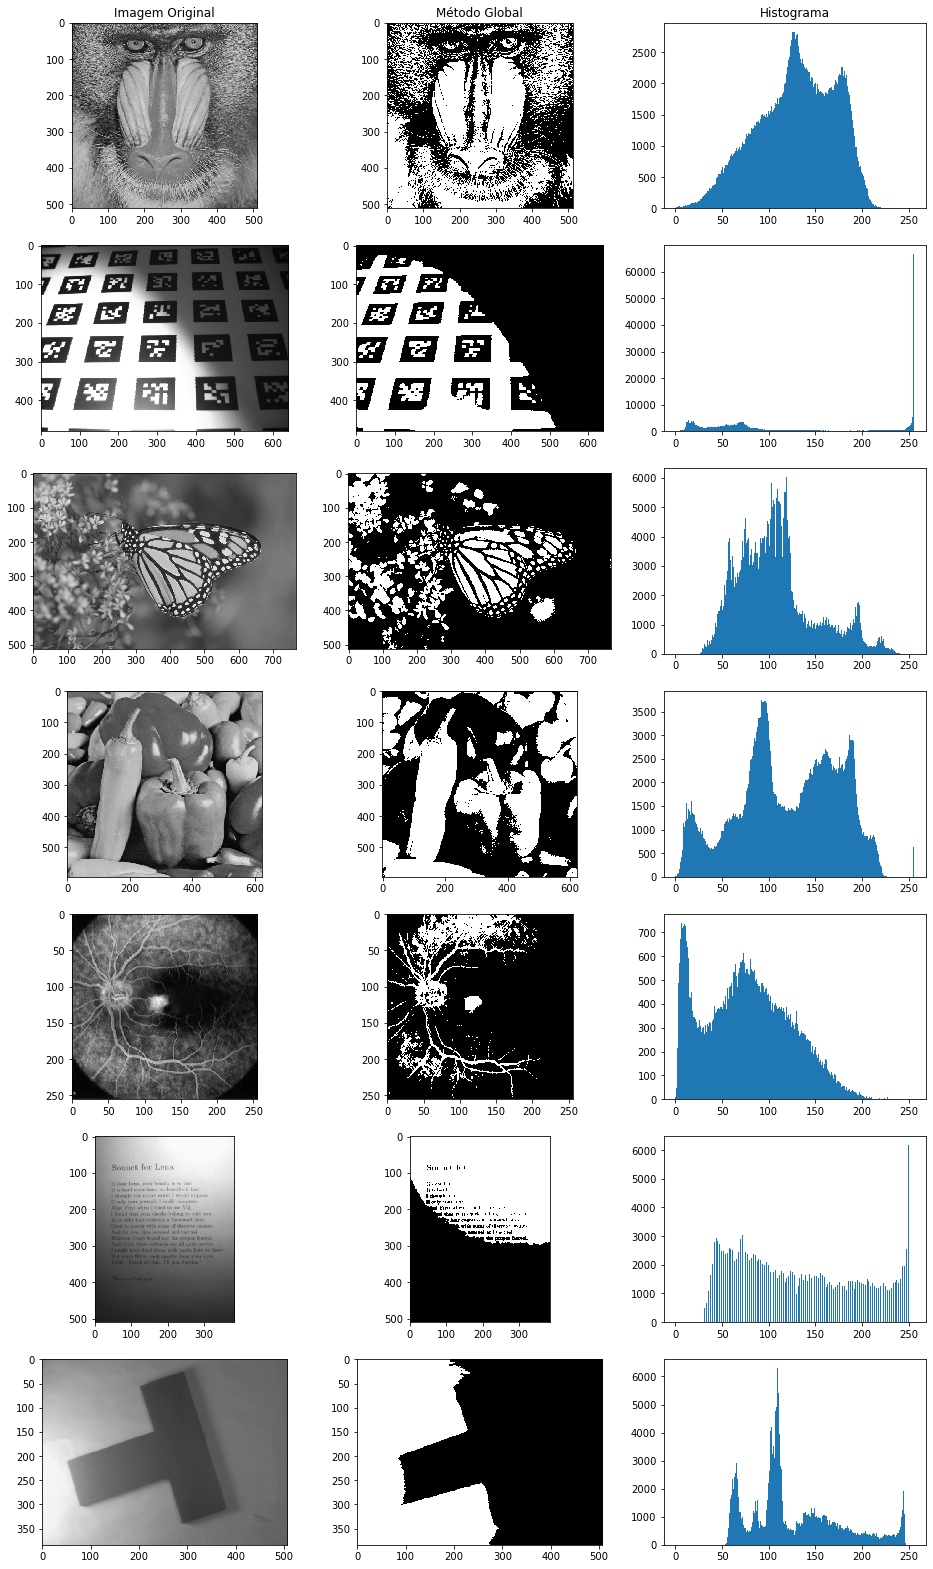

In [2]:
global_thresholding = lambda i: np.where(i < 128, 0, 255)

threshold('Método Global', global_thresholding)

## Método de Otsu

Limite escolhido:122.0
Limite escolhido:149.0
Limite escolhido:130.0
Limite escolhido:119.0
Limite escolhido:79.0
Limite escolhido:141.0
Limite escolhido:140.0


Imagem  Porcentagem
0    baboon     40.8993%
1  fiducial     64.1348%
2   monarch     78.7252%
3   peppers     49.5014%
4    retina     53.5324%
5    sonnet     57.1604%
6     wedge     66.3821%

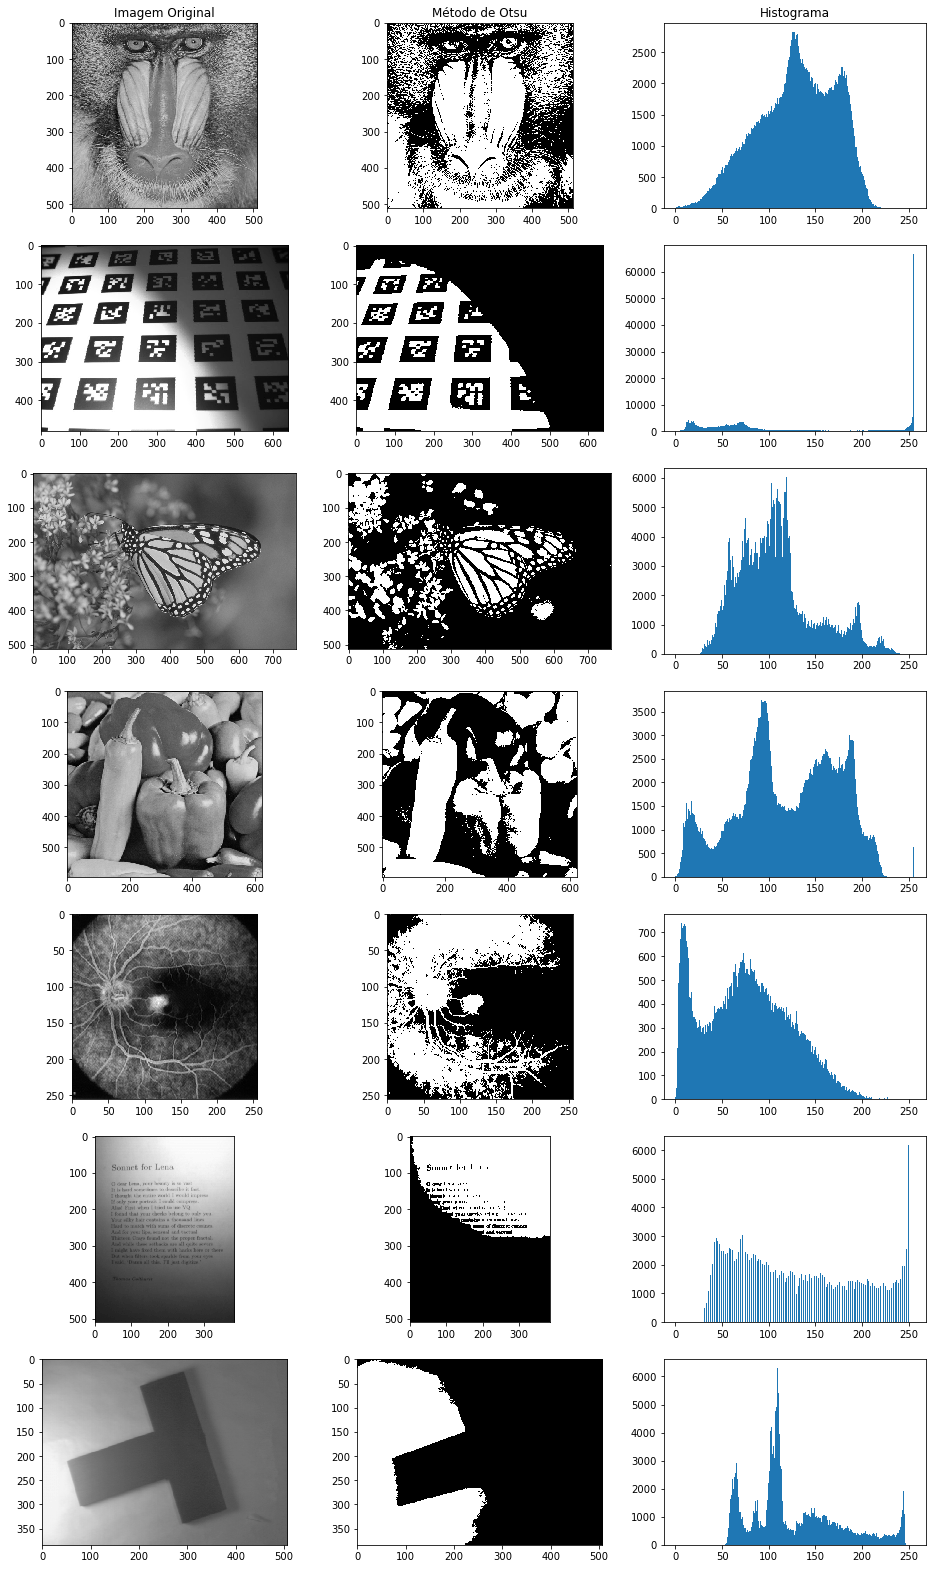

In [3]:
import cv2 as cv

def otsu_thresholding(img):
    ret,th = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    print(f'Limite escolhido:{ret}')
    return th

threshold('Método de Otsu', otsu_thresholding)

## Método de Bernsen

Imagem  Porcentagem
0    baboon     45.8305%
1  fiducial     36.1930%
2   monarch     52.5500%
3   peppers     46.6449%
4    retina     73.2071%
5    sonnet     27.1691%
6     wedge     43.3473%

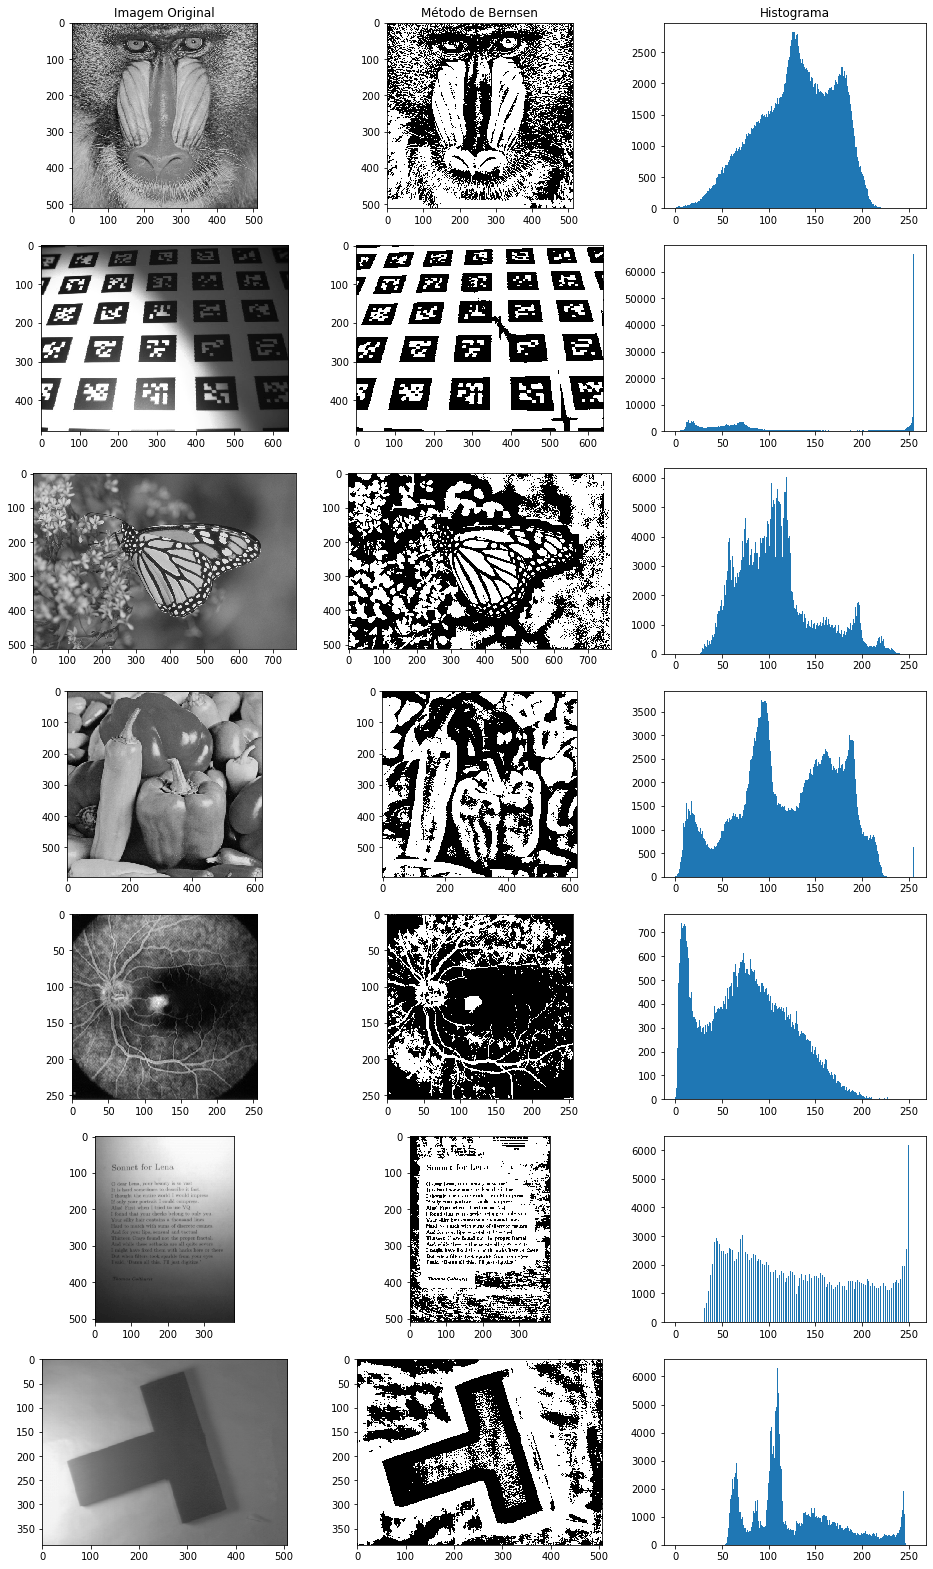

In [4]:
def get_bernsen(region):
    local_min = int(np.min(region))
    local_max = int(np.max(region))
    
    return (local_min + local_max) / 2

threshold('Método de Bernsen', get_local_threshold_function(20, get_bernsen))

## Método de Niblack

Imagem  Porcentagem
0    baboon     30.1350%
1  fiducial     33.4495%
2   monarch     29.0118%
3   peppers     26.2532%
4    retina     32.8308%
5    sonnet     16.5819%
6     wedge     21.5899%

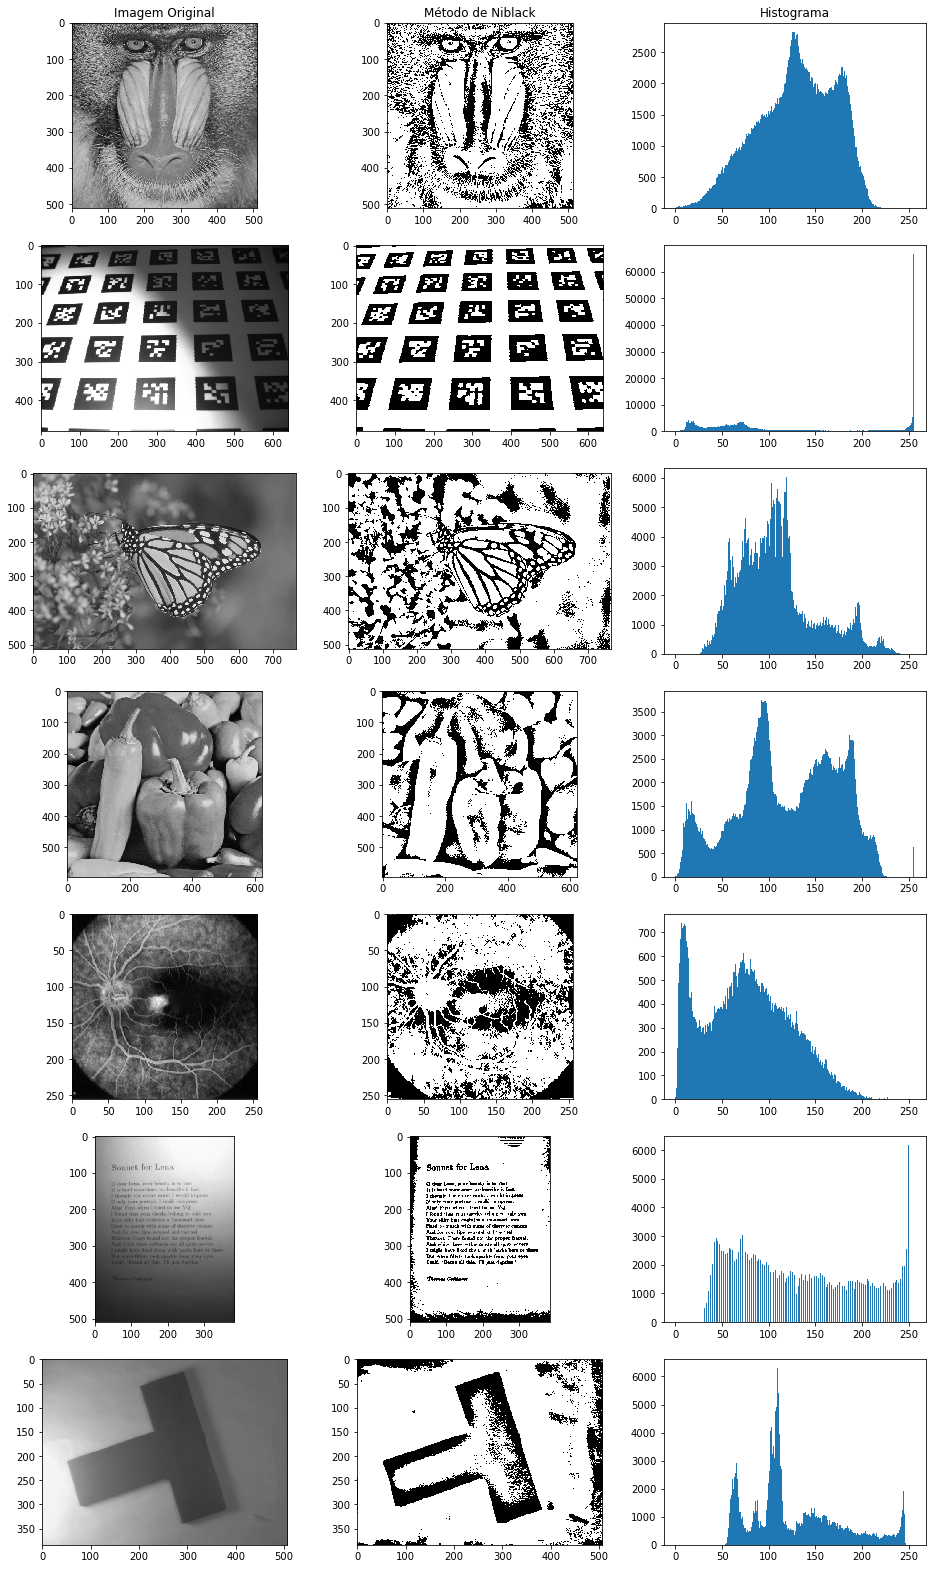

In [5]:
def get_niblack(k):
    return lambda i: np.mean(i) + k * np.std(i)

threshold('Método de Niblack', get_local_threshold_function(40, get_niblack(-0.5)))

## Método de Sauvola e Pietaksinen

Imagem  Porcentagem
0    baboon     10.8521%
1  fiducial     32.8555%
2   monarch     11.0985%
3   peppers     14.8680%
4    retina     22.0749%
5    sonnet      0.0296%
6     wedge      0.0760%

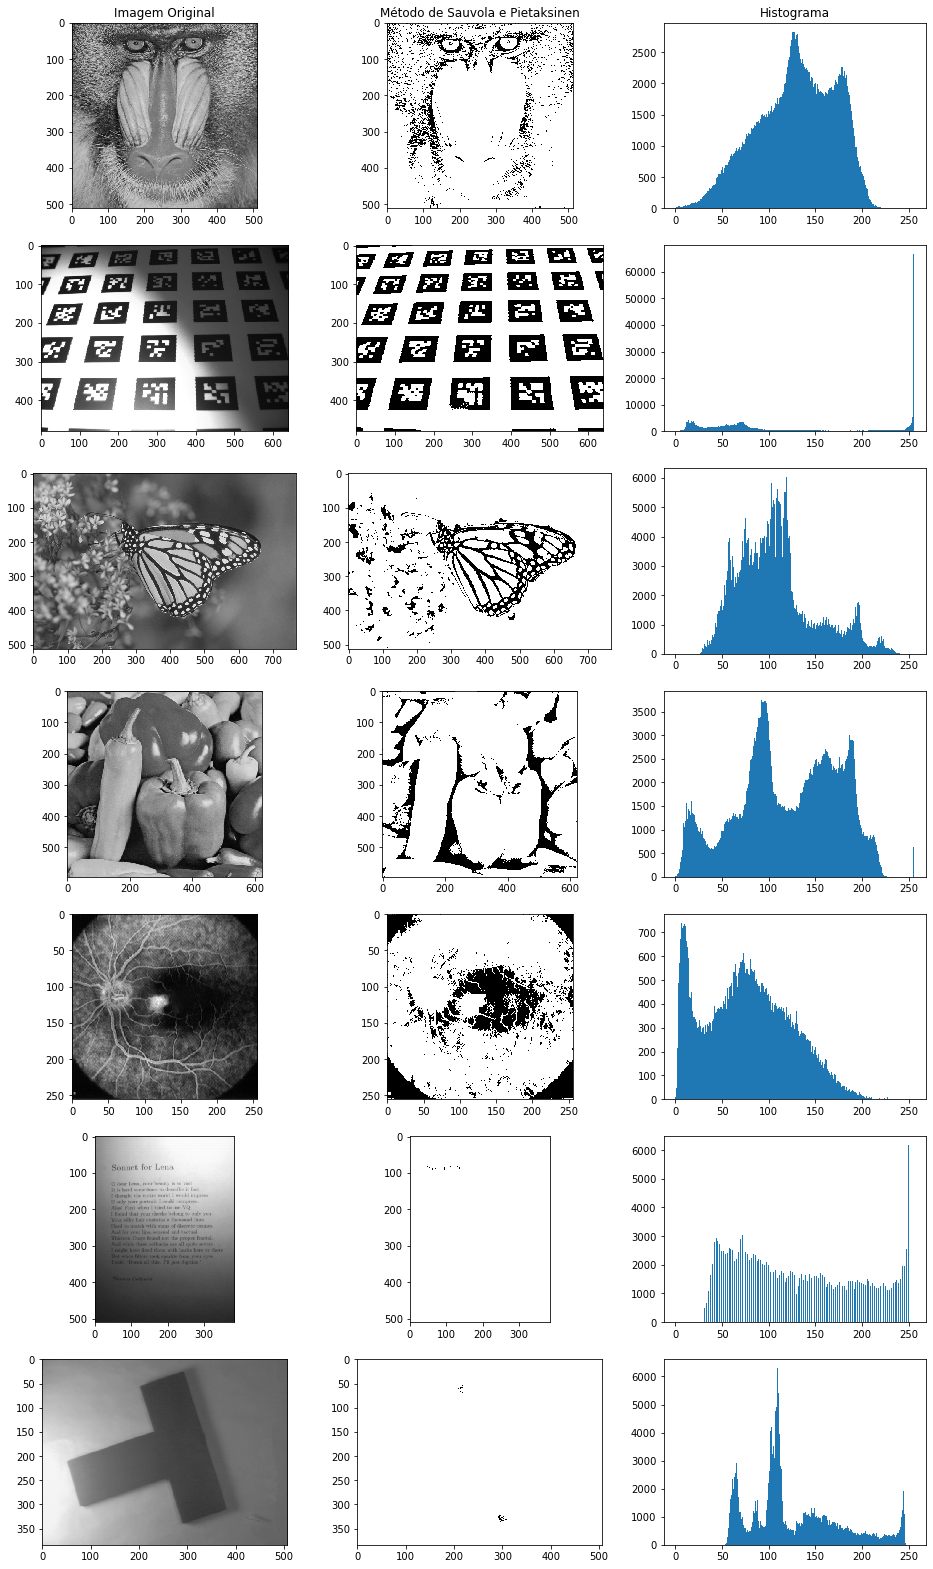

In [6]:
def get_sauvola_pietaksinen(k, R):
    return lambda i: np.mean(i) * (1 + k * (np.std(i) / R - 1))

threshold('Método de Sauvola e Pietaksinen', get_local_threshold_function(40, get_sauvola_pietaksinen(0.5, 128)))

## Método de Phansalskar, More e Sabale

Imagem  Porcentagem
0    baboon     29.2477%
1  fiducial     45.2939%
2   monarch     34.8834%
3   peppers     37.3651%
4    retina     51.8417%
5    sonnet     24.3770%
6     wedge     24.5850%

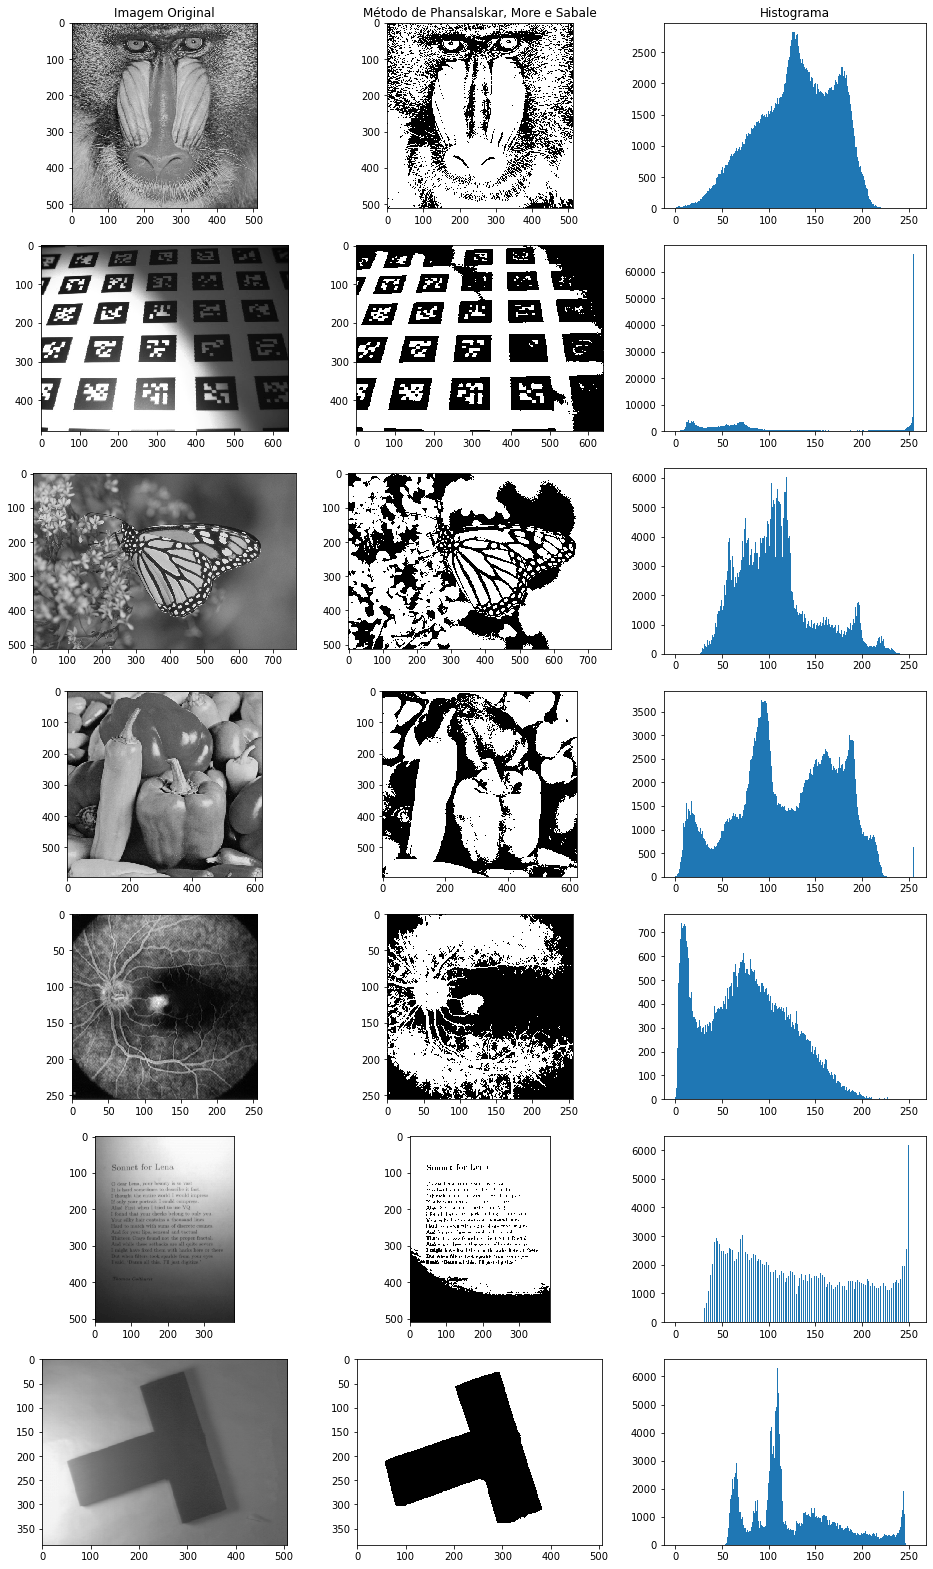

In [7]:
import math

def get_phansalskar_more_sabale(k, R, p, q):
    def calc_phansalskar_more_sabale(region):
        m = np.mean(region) / 255
        s = np.std(region) / 255
        return 255 * m * (1 + p * math.exp(-q * m) + k * (s / R - 1))
    return calc_phansalskar_more_sabale

threshold('Método de Phansalskar, More e Sabale', get_local_threshold_function(80, get_phansalskar_more_sabale(0.25, 0.5, 3, 10)))

## Método do Contraste

Imagem  Porcentagem
0    baboon     46.3421%
1  fiducial     36.4277%
2   monarch     54.7722%
3   peppers     47.3553%
4    retina     73.7839%
5    sonnet     37.8002%
6     wedge     49.6297%

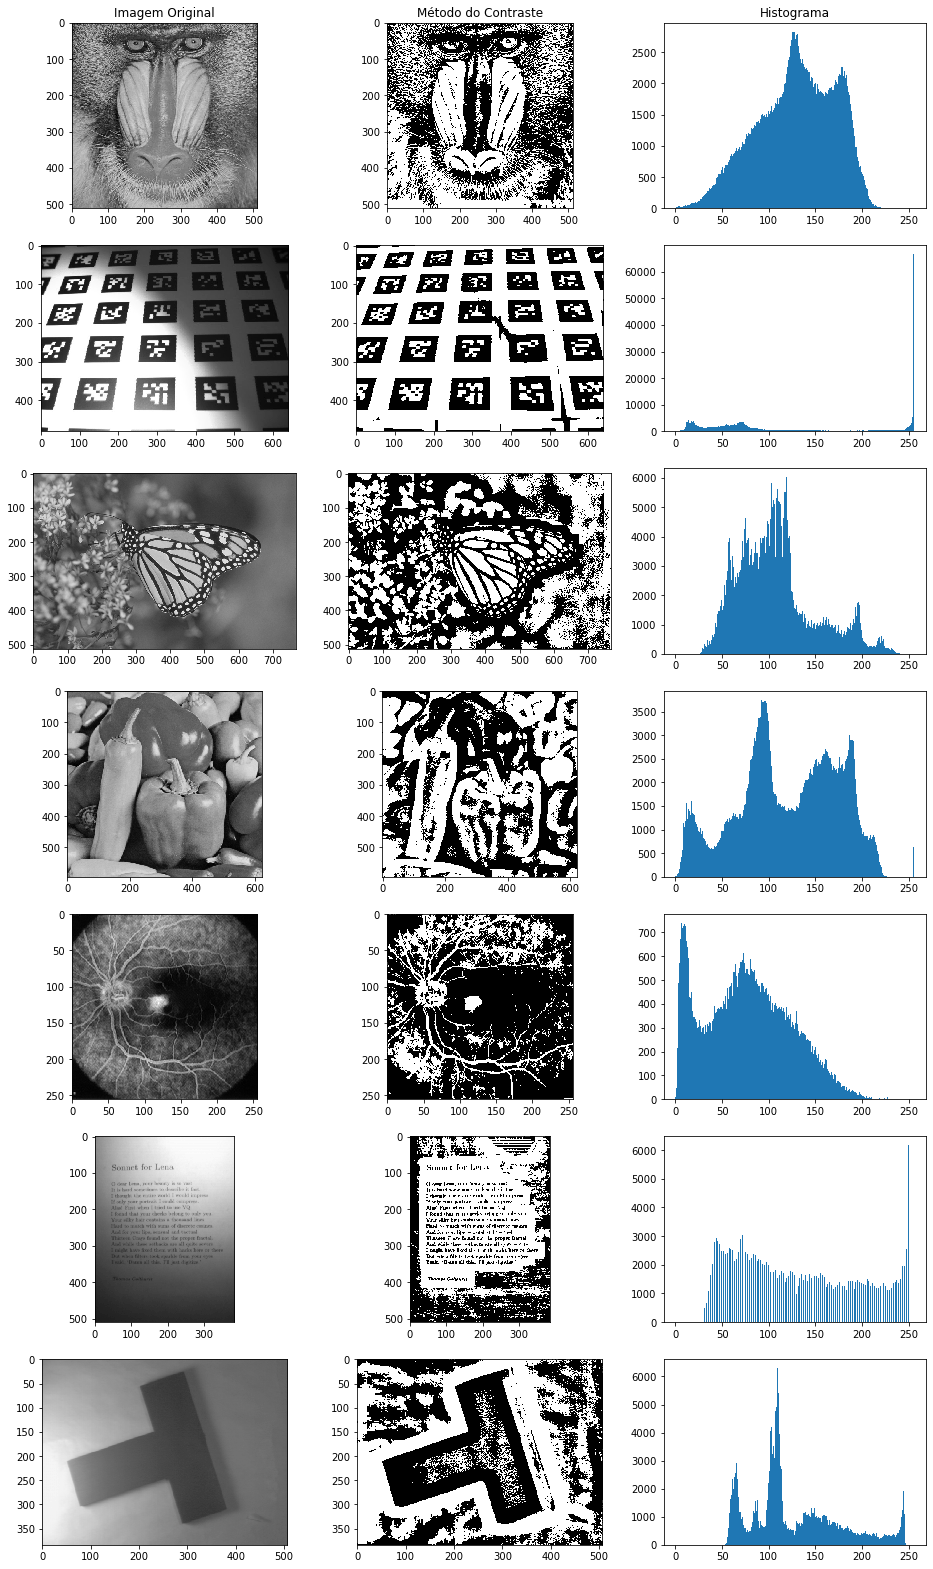

In [8]:
def get_contrast(region, value):
    local_min = np.min(region)
    local_max = np.max(region)
    
    return -1 if value - local_min > local_max - value else 256

threshold('Método do Contraste', get_local_threshold_function(20, get_contrast, needs_value=True))

## Método da Média

Imagem  Porcentagem
0    baboon     47.9431%
1  fiducial     36.4137%
2   monarch     51.8776%
3   peppers     46.8319%
4    retina     57.4966%
5    sonnet     41.6279%
6     wedge     49.2285%

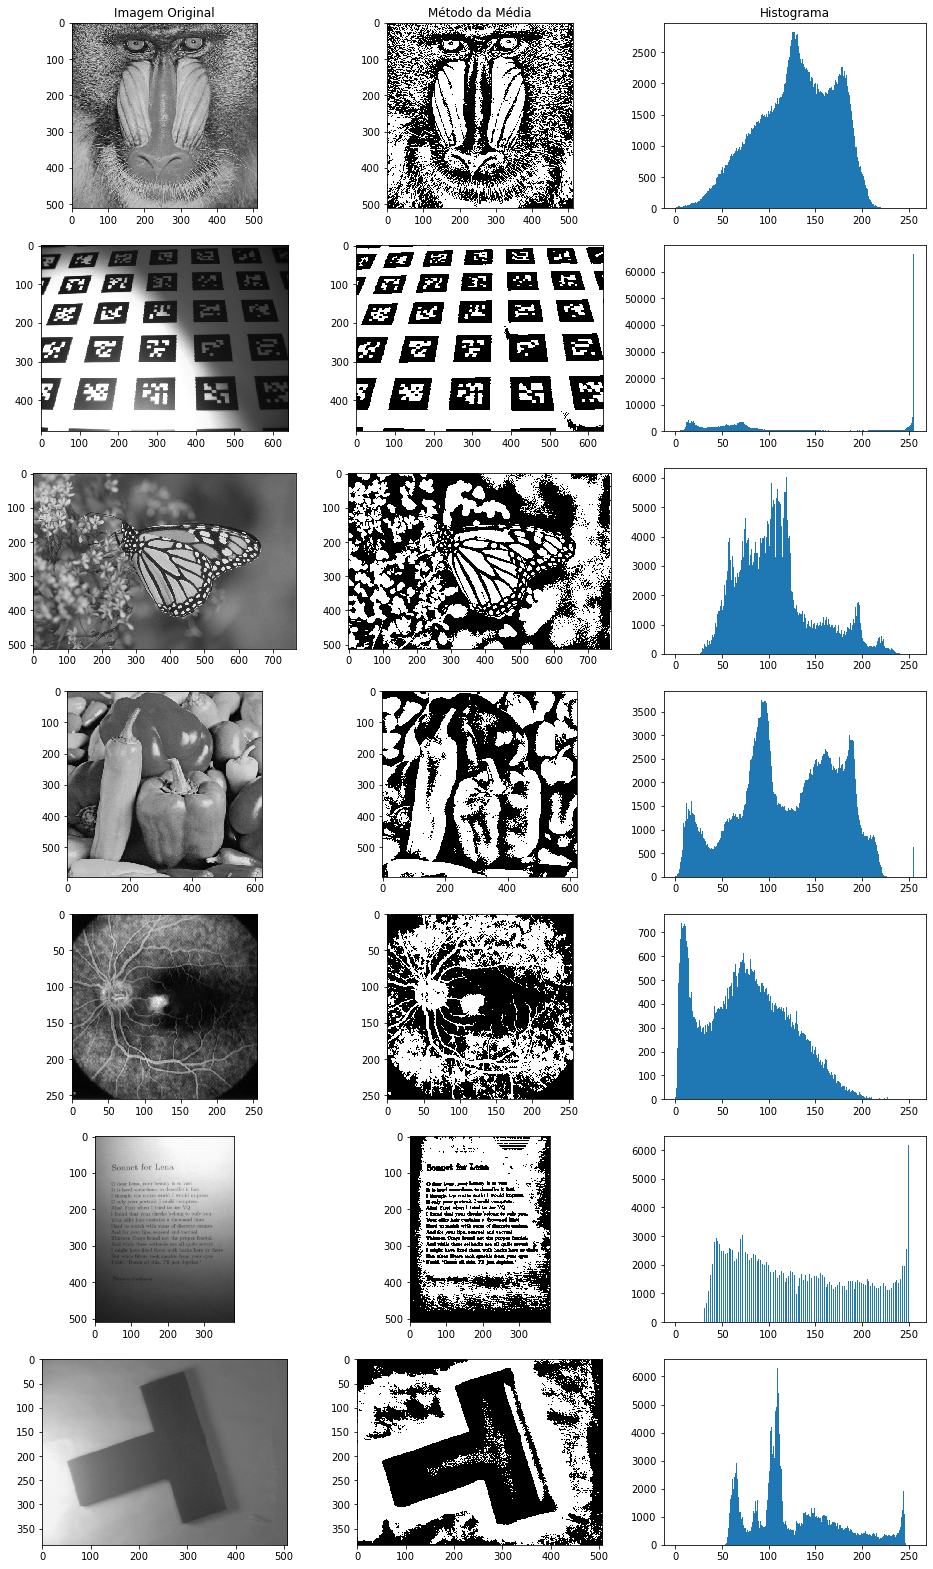

In [9]:
threshold('Método da Média', get_local_threshold_function(40, np.mean))

## Método da Mediana

Imagem  Porcentagem
0    baboon     48.7759%
1  fiducial     40.0866%
2   monarch     48.4830%
3   peppers     46.4898%
4    retina     52.9404%
5    sonnet     31.6539%
6     wedge     41.0056%

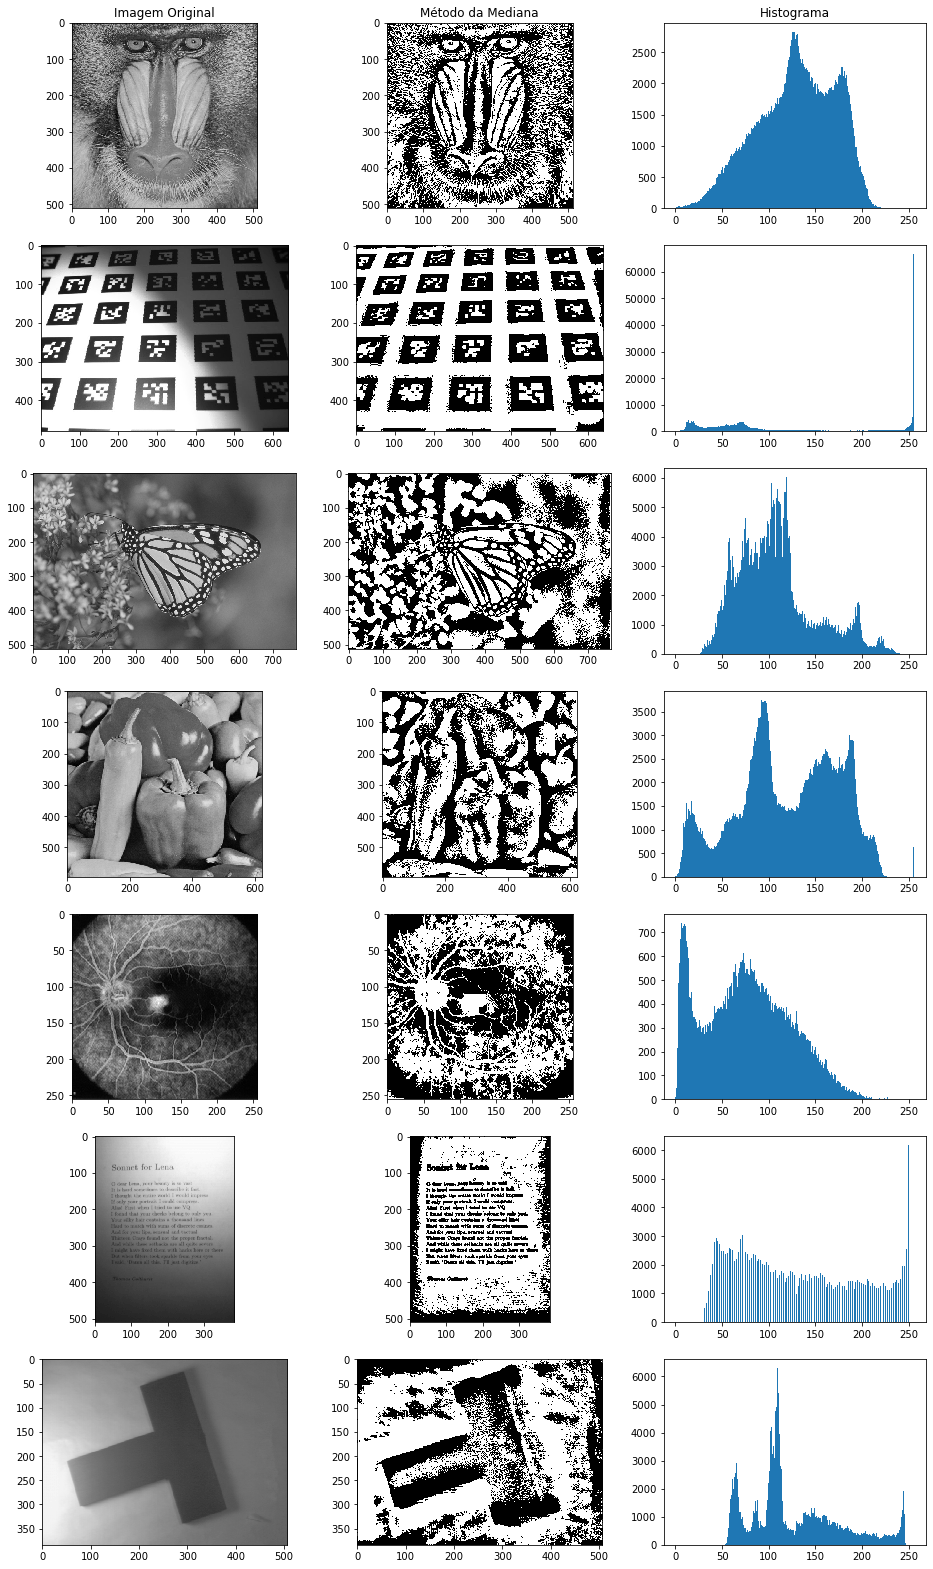

In [10]:
threshold('Método da Mediana', get_local_threshold_function(40, np.median))